## Initialization

import libraries.

In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark
import pyspark.pandas as ps
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import *
from pyspark.ml.feature import *
from sklearn.preprocessing import LabelEncoder 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns
from collections import Counter, defaultdict


from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

plt.style.use('seaborn')


Let's start spark session and set *log* level to ERROR.

In [ ]:
 spark = SparkSession.builder \
     .master("local") \
     .appName("Group project") \
     .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
     .getOrCreate()

#'spark = SparkSession.builder \
#.master("local") \
#.appName("Group project") \
#.config("spark.sql.execution.arrow.pyspark.enabled", "true") \
#.config("spark.driver.memory", "16g") \
#.getOrCreate()'


if IN_COLAB : 
    spark.sparkContext.addPyFile('graphframes-0.8.2-spark3.2-s_2.12.jar')
else:
    spark.sparkContext.addPyFile('/usr/local/spark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar')

spark.sparkContext.setCheckpointDir("checkpoint")


# Cleaning Data

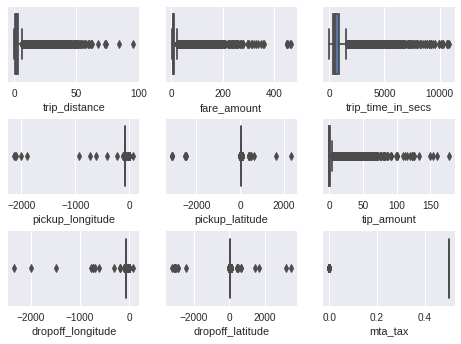

In [ ]:
# initialize spark session
spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

mySchema = StructType([
    StructField("medallion", StringType()),
    StructField("hack_license", StringType()),
    StructField("pickup_datetime", TimestampType()),
    StructField("dropoff_datetime", TimestampType()),
    StructField("trip_time_in_secs", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", StringType()),
    StructField("fare_amount", DoubleType()),
    StructField("surcharge", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("total_amount", DoubleType()),
])

dataset = spark.read.load(FILENAME, format="csv", 
                         sep=",", schema=mySchema, header="false")

# transform dataset to pandas dataset
pandas_df = dataset.toPandas()
# show the boxplot for longitude and latitude data for pickups, and more data
fig, ax = plt.subplots(3,3)
fig.subplots_adjust(hspace=.5)
sns.boxplot(x=pandas_df['trip_distance'], ax=ax[0, 0])
sns.boxplot(x=pandas_df['fare_amount'], ax=ax[0, 1])
sns.boxplot(x=pandas_df['trip_time_in_secs'], ax=ax[0,2])
sns.boxplot(x=pandas_df['pickup_longitude'], ax=ax[1,0])
sns.boxplot(x=pandas_df['pickup_latitude'], ax=ax[1,1])
sns.boxplot(x=pandas_df['tip_amount'], ax=ax[1,2])
sns.boxplot(x=pandas_df['dropoff_longitude'], ax=ax[2,0])
sns.boxplot(x=pandas_df['dropoff_latitude'], ax=ax[2,1])
sns.boxplot(x=pandas_df['mta_tax'], ax=ax[2,2])

fig.show()

First, it is important to have a look at the dataset to see if there need to be made some changes. To identify if there are any outliers, boxplots are drawn. 

For trip distance and fare amount it can be seen that the values are distributed between 0 and 95/450. There are just very few high values but they wont be excluded because they make sense when there was a long trip the distance is very high as well as the fare amount. Though, on the other end there are null values included. That does not make a lot of sense as the trip distance and the fare amount should be greater than zero. Thus, in the following step null values for these columns will be excluded. 

Having a look at the geospatial data it can be noticed that the values are very centrated with a few outliers. Some outliers can be clearly defined as wrong as there are no longitudes as -2000. There must be a mistake in the data. In the case the presented data is from New York so only geospartial data from New York should be included. In the following step the geospartial data is limited for pickup and dropoff data to a big range around New York to exclude all the outliers. 

We clean both the medium sized and the small dataset, since we use the small dataset for Exercise 5.

### Cleaning the dataset

In [ ]:
dataset.createOrReplaceTempView("data")
spark_df = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    pickup_longitude, 
                                    pickup_latitude,
                                    dropoff_longitude, 
                                    dropoff_latitude, 
                                    payment_type, fare_amount, surcharge, mta_tax, 
                                    tip_amount, tolls_amount, total_amount, 
                                    ROUND(fare_amount + surcharge + mta_tax + tip_amount + tolls_amount,2) AS total_amount_manual,
                                    ROUND(trip_distance / (trip_time_in_secs / 3600),2) AS speed_mph
                                  FROM data
                                  WHERE (payment_type LIKE "CSH" OR payment_type LIKE "CRD") AND
                                  fare_amount > 0 AND
                                  tip_amount BETWEEN 0 AND 100 AND
                                  mta_tax = 0.5 AND
                                  tolls_amount BETWEEN 0 AND 30 AND
                                  trip_time_in_secs > 60 AND
                                  trip_distance > 0.2 AND
                                  pickup_longitude > -78.0 AND pickup_longitude < -71.0 AND
                                  dropoff_longitude > -78.0 AND dropoff_longitude < -71.0 AND
                                  pickup_latitude > 38.0 AND pickup_latitude < 43.0 AND
                                  dropoff_latitude > 38.0 AND dropoff_latitude < 43.0 """ ).createOrReplaceTempView("data")

spark_df = spark.sql(""" SELECT * FROM data WHERE total_amount = total_amount_manual AND speed_mph <= 100""")

spark_df.show(5)
spark_df.count()

+--------------------+--------------------+-------------------+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+-------------------+---------+
|           medallion|        hack_license|    pickup_datetime|   dropoff_datetime|trip_time_in_secs|trip_distance|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|total_amount_manual|speed_mph|
+--------------------+--------------------+-------------------+-------------------+-----------------+-------------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+-------------------+---------+
|07290D3599E7A0D62...|E7750A37CAB07D0DF...|2013-01-01 00:00:00|2013-01-01 00:02:00|              120|         0.44|   

1919983

### Cleaning rationale

After looking at the bookplots, we cleaned the data in the following way:
- exclude any payment method besides CSH (cash) or CRD (credit card)
- fare_amount must be greater than 0
- tips outside the range of 0 and 100 are considered outliers
- after conducting some research, found out that mta_tax for all cabs starting or ending in NY must be 0.5
- only a tolls_amount between 0 and 30 was deemed realistic
- trips shorter than 1 minute shouldn't be considered
- trips shorter than 0.2 miles shouldn't be considered
- greater New York state area is the square between -78 and -71 longitude, and 38 and 43 latitude (to exclude extreme outliers)
- the newly created speed_mph column was used to eliminate rides with a speed above 100 mph
- the newly created total_amount_manual column manually summed up the bill items, to ensure that the total_amount column is equal to the manually calculated sum (all not matching rows will be excluded)

## Exercise 1

Let's start by trying to help the city to identify which new bus routes should be introduced. To this end, you should find the most frequent routes whose distance is above a given treshold (defined by you).

For establishing these routes, we suggest that you use a grid of 500m of side.

In [ ]:
# Squares of 500 meters
latitudeStep = 0.004491556
longitudeStep = 0.005986
northLatitude = 41.474937 - 0.5 * latitudeStep
southLatitude = northLatitude - 300 * latitudeStep
eastLongitude = -74.913585 - 0.5 * longitudeStep
westLongitude = eastLongitude + 300 * longitudeStep

# function to round longitude to a point in the middle of the square
def longiRound( val):
    return ((val - eastLongitude) // longitudeStep) * longitudeStep + eastLongitude + longitudeStep / 2
spark.udf.register("longround", longiRound, DoubleType())

# function to round latitude to a point in the middle of the square
def latRound( l):
    return northLatitude - ((northLatitude - l) // latitudeStep) * latitudeStep - latitudeStep / 2
spark.udf.register("latround", latRound, DoubleType())


# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
spark_df.createOrReplaceTempView("data")
filteredDataDF = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    longround(pickup_longitude) AS pickup_longitude, 
                                    latround(pickup_latitude) AS pickup_latitude,
                                    longround(dropoff_longitude) AS dropoff_longitude, 
                                    latround(dropoff_latitude) AS dropoff_latitude, 
                                    payment_type, fare_amount, mta_tax, 
                                    tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= """ + str(eastLongitude) + """ AND
                                  pickup_longitude <=  """ + str(westLongitude) + """ AND
                                  dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                                  dropoff_longitude <=  """ + str(westLongitude) + """ AND
                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                  dropoff_latitude >=  """ + str(southLatitude))
filteredDataDF.createOrReplaceTempView("data")

# Frequent routes 
frequent_routes = spark.sql( """SELECT pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude, AVG(trip_distance) as trip_distance, 
                                  COUNT(*) AS frequent_routes
                                  FROM data
                                  WHERE trip_distance > 5.0
                                  GROUP BY pickup_latitude, pickup_longitude, dropoff_latitude, dropoff_longitude
                                  ORDER BY frequent_routes DESC
                                  LIMIT 10""")


frequent_routes.show()

+------------------+----------------+------------------+-----------------+------------------+---------------+
|   pickup_latitude|pickup_longitude|  dropoff_latitude|dropoff_longitude|     trip_distance|frequent_routes|
+------------------+----------------+------------------+-----------------+------------------+---------------+
| 40.77425426399999|      -73.872021|40.756288039999994|       -73.973783| 9.843834586466166|            665|
| 40.76077959599999|      -73.985755| 40.77425426399999|       -73.872021|10.826520076481842|            523|
| 40.77425426399999|      -73.872021| 40.76077959599999|       -73.979769|10.306381709741549|            503|
| 40.77425426399999|      -73.872021| 40.76077959599999|       -73.985755|10.423843058350101|            497|
| 40.77425426399999|      -73.872021|40.756288039999994|       -73.985755| 9.977287449392716|            494|
| 40.77425426399999|      -73.872021| 40.75179648399999|       -73.973783| 9.065762004175365|            479|
| 40.76077

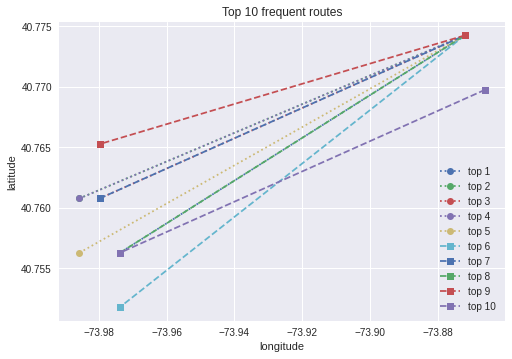

In [ ]:
# transform dataset to pandas dataframe
pandasDF = frequent_routes.toPandas()

# store the latitudes and longitudes in x, y value
x_value = []
y_value = []

for index, row in pandasDF.iterrows():
    x_values = [row['pickup_longitude'], row['dropoff_longitude']]
    y_values = [row['pickup_latitude'], row['dropoff_latitude']]
    x_value.append(x_values)
    y_value.append(y_values)

# plot the top 10 routes
plt.plot(x_value[0], y_value[0], label = "top 1", linestyle = 'dotted', marker = 'o')
plt.plot(x_value[1], y_value[1], label = "top 2", linestyle = 'dotted', marker = 'o')
plt.plot(x_value[2], y_value[2], label = "top 3", linestyle = 'dotted', marker = 'o')
plt.plot(x_value[3], y_value[3], label = "top 4", linestyle = 'dotted', marker = 'o')
plt.plot(x_value[4], y_value[4], label = "top 5", linestyle = 'dotted', marker = 'o')
plt.plot(x_value[5], y_value[5], label = "top 6", linestyle = '--', marker = 's')
plt.plot(x_value[6], y_value[6], label = "top 7", linestyle = '--', marker = 's')
plt.plot(x_value[7], y_value[7], label = "top 8", linestyle = '--', marker = 's')
plt.plot(x_value[8], y_value[8], label = "top 9", linestyle = '--', marker = 's')
plt.plot(x_value[9], y_value[9], label = "top 10", linestyle = '--', marker = 's')

plt.legend()
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title("Top 10 frequent routes")

plt.show()

**For the top 3:** 

1) Pickup at La Guardia Airport 

Dropoff at Waldorf Astoria Hotel

2) Pickup at The Ritz Plaza Hotel

Dropoff at La Guardia Airport

3) Pickup at La Guardia Airport

Dropoff at 6th Avenue


#### **Discussion**

To help the city decide on a bus route, we first created 500m squares for pickup and dropoff locations. Then we created a new dataframe that contains the top 10 frequent routes. To do so, we grouped by the pickup and dropoff location and counted the routes that had the same locations. Furthermore, we took the average drip distance for the grouped values and decided to just include trip distances over 5 miles. We decided on 5 miles as we wanted to exclude the short distance city bus routes and rather have a look at the medium and long routes. Lastly, we ordered the dataframe by the frequent routes and just showed the top 10 frequent routes. 
After that, we wanted to visualize the top 10 frequent routes because it is difficult to understand the frequent routes by just looking at the coordinates. 
The visualization shows a very interesting picture. 9 of the top 10 routes either start or end at the same coordinate. This coordinate belongs to the La Guardia Airport. After having a more detailed look it can be noticed that there are three lines that have the same route (green - top 8 and blue - top 1), (blue - top 7 and red - top top 3) and (purple - top 4 and green - top 2) just that the start and end points are switched up. The last two same routes are even very closely located next to each other. One recommendation is definitely to implement a bus route between both routes where a bus goes forth and back all the time. Then we can also suggest the first same route as a route that should be implemented with a bus (green, blue)

## Exercise 2

The taxi trips can be classified in two categories, depending on whether the client has given a tip or not (or alternatively in three categories - no tip, low percentage tip, high percentage tip). Propose a method to predict the class of a given trip (for the prediction, you cannot use the value of the tip).


### Create new DataFrame

In [ ]:
spark_df.createOrReplaceTempView("data")
classification_spark = spark.sql("""SELECT medallion, hack_license, pickup_datetime, dropoff_datetime,
                    dayofweek(pickup_datetime) AS day, 
                    hour(pickup_datetime) AS hour,
                    trip_time_in_secs, trip_distance, speed_mph,
                    pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude,
                    payment_type, fare_amount, surcharge, mta_tax, tip_amount, tolls_amount, total_amount,
                    tip_amount/total_amount AS tip_percentage
                    FROM data """)

In [ ]:
from pyspark.sql import functions as f

# add a new column that classifies into tip (1) or no tip (0)
classification_spark = classification_spark.withColumn('received_tip', f.when(f.col('tip_amount') > 0, 1).otherwise(0))
# add a new column that classifies into weekend (1) or work day (0)
classification_spark = classification_spark.withColumn('weekend', f.when((f.col('day') == 1) | (f.col('day') == 7), 1).otherwise(0))
# add a new column that classifies into tipclass no tip (0), low tip (1), high tip (2)
classification_spark = classification_spark.withColumn('tip_class', f.when((f.col('tip_percentage') == 0), 0).when(col("tip_percentage") >= 0.15, 2).otherwise(1))
# add a new column that classifies into cash (0) or credit card payment (1)
classification_spark = classification_spark.withColumn('payment', f.when((f.col('payment_type') == "CSH"), 0).otherwise(1))

classification_spark.show(5)

+--------------------+--------------------+-------------------+-------------------+---+----+-----------------+-------------+---------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+--------------+------------+-------+---------+-------+
|           medallion|        hack_license|    pickup_datetime|   dropoff_datetime|day|hour|trip_time_in_secs|trip_distance|speed_mph|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|payment_type|fare_amount|surcharge|mta_tax|tip_amount|tolls_amount|total_amount|tip_percentage|received_tip|weekend|tip_class|payment|
+--------------------+--------------------+-------------------+-------------------+---+----+-----------------+-------------+---------+----------------+---------------+-----------------+----------------+------------+-----------+---------+-------+----------+------------+------------+--------------+------------+-------+--------

### EDA (in Spark)

Try to find out which variables influence the tip. First, we did a correlation analysis, and found out that out of all variables (that are not directly related to the tip), the total_amount, payment, fare_amount, and trip_distance are the most highly correlated to the tip amount

In [ ]:
classification_spark.createOrReplaceTempView("classification")

corrDF = spark.sql(""" SELECT hour, trip_time_in_secs, trip_distance, speed_mph, pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude,
                      fare_amount, surcharge, tip_amount, tolls_amount, total_amount, tip_percentage, received_tip, weekend, payment
                      FROM classification""")

corrDF_pd = corrDF.toPandas()

In [ ]:
corrDF_pd.corr().abs().loc["tip_amount"].sort_values(ascending=False)

tip_amount           1.000000
tip_percentage       0.690198
total_amount         0.639697
received_tip         0.634223
payment              0.612689
fare_amount          0.512463
trip_distance        0.497559
trip_time_in_secs    0.443982
tolls_amount         0.363206
speed_mph            0.318949
pickup_longitude     0.242930
dropoff_longitude    0.153221
pickup_latitude      0.147402
dropoff_latitude     0.110927
weekend              0.013894
surcharge            0.013322
hour                 0.007890
Name: tip_amount, dtype: float64

Then we wanted to find out, if the tip is influenced by the day, the hour, or if the trip lies on a weekend or not.

In [ ]:
spark.sql("""SELECT day, MEAN(tip_amount) as mean_tip FROM classification GROUP BY day SORT BY mean_tip desc""").show() # where day 1 = sunday

+---+------------------+
|day|          mean_tip|
+---+------------------+
|  2|1.3096904224443624|
|  1|1.2674176038992102|
|  4|1.2656862832189448|
|  3|1.2180845464340455|
|  5|1.1570385948046138|
|  6|1.1274747160212328|
|  7|1.0706097633994398|
+---+------------------+



In [ ]:
spark.sql("""SELECT weekend, MEAN(tip_amount) as mean_tip FROM classification GROUP BY weekend SORT BY mean_tip desc""").show() # where day 1 = weekend

+-------+------------------+
|weekend|          mean_tip|
+-------+------------------+
|      0|1.2203405253646866|
|      1|1.1521119155493218|
+-------+------------------+



In [ ]:
spark.sql("""SELECT hour, MEAN(tip_amount) as mean_tip FROM classification GROUP BY hour SORT BY mean_tip desc""").show() 

+----+------------------+
|hour|          mean_tip|
+----+------------------+
|   5|1.6317185821697044|
|  23|1.3265972088731741|
|  21|1.3200064195759333|
|  22|1.3139875606765927|
|  20| 1.292843153065979|
|   6|   1.2829221272322|
|   8| 1.268097075241935|
|   0|1.2666833934451949|
|   1| 1.231916372486681|
|   9|1.2284059625546386|
|   4| 1.226472323049002|
|   7|   1.2188756722643|
|  19| 1.197680963763569|
|  18|1.1891380712824695|
|  16|1.1732384640351026|
|  17|1.1702714346863257|
|   3|  1.16432582892756|
|   2|  1.16069651336318|
|  15|1.1530512907643755|
|  14|1.1527860186688368|
+----+------------------+
only showing top 20 rows



One can see a very slight increase in tips during the night and rush hours.

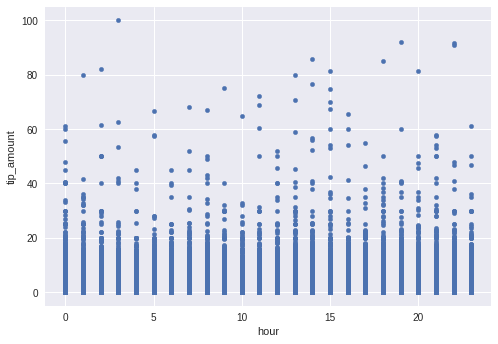

In [ ]:
tip_hour = spark.sql("""SELECT tip_amount, hour FROM classification""")
tip_hour_pd = tip_hour.toPandas()
tip_hour_pd.plot.scatter(x="hour", y="tip_amount")

Most highly correlated to the tip amount is total_amount, payment, and fare_amount, trip_distance

In [ ]:
tip_df = spark.sql(""" SELECT total_amount, payment, fare_amount, trip_distance, hour, received_tip, tip_percentage, tip_class FROM classification""")
tip_df.show(5)

+------------+-------+-----------+-------------+----+------------+--------------+---------+
|total_amount|payment|fare_amount|trip_distance|hour|received_tip|tip_percentage|tip_class|
+------------+-------+-----------+-------------+----+------------+--------------+---------+
|         4.5|      0|        3.5|         0.44|   0|           0|           0.0|        0|
|         5.0|      0|        4.0|         0.71|   0|           0|           0.0|        0|
|         5.0|      0|        4.0|         0.48|   0|           0|           0.0|        0|
|         5.0|      1|        4.0|         0.61|   0|           0|           0.0|        0|
|         7.5|      0|        6.5|         1.71|   0|           0|           0.0|        0|
+------------+-------+-----------+-------------+----+------------+--------------+---------+
only showing top 5 rows



### **Logistics regression model (in Pandas)**

In [ ]:
tip_df_pd = tip_df.toPandas()

/usr/local/lib/python3.8/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Text(0.5, 28.5, 'Predicted label')

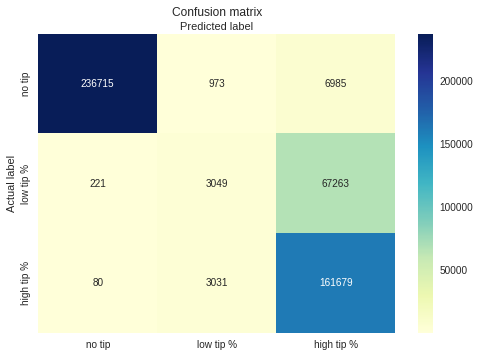

In [ ]:
# --1: define features and labels, and split into training and test data
y = tip_df_pd[['tip_class']] # want to predict 0,1,2
x = tip_df_pd[["total_amount", "trip_distance", "payment", "hour"]]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=123)

# --2: and create a Logistic Regression classifier object using LogisticRegression() function.
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=2000000)

# --3: fit your model on the dataset using fit()
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

# previosuly built model, in y_pred have predictions for test set
# compute confusion metrics with actual (test) values and predictions for test set
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names=["No tip", "Low percentage", "High percentage"] # name  of classes

fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
ax.xaxis.set_ticklabels(['no tip', 'low tip %', "high tip %"])
ax.yaxis.set_ticklabels(['no tip', 'low tip %', "high tip %"])
#plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [ ]:
print("Precision:", metrics.precision_score(y_test, y_pred, average=None) * 100)
print("Recall:", metrics.recall_score(y_test, y_pred, average=None) * 100)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred) * 100)

Precision: [99.87300435 43.22983128 68.52924845]
Recall: [96.74749564  4.32279926 98.11214273]
Accuracy: 83.63465528879406


#### Discussion

**Explain your code and discuss results**

We wanted to predict the class of a given tip with classification by a (multinomial) logistic regression model. A tip was either classified as "no tip", "low tip", or "high tip". The distinction between low tip and high tip was made based on the custom, to tip between 10-20%, where a 20% tip is often already considered high. Therefore it was decided to classify tip percentages below 15% as low tip. 

The features used to train the model were found during an exploratory data analysis (see above for explanation). 

The resulting model can be evaluated with a confusion matrix. The interpretation however, is in the case of a multi-class classification, is a bit different, since we don't really have "positivies" and "negatives".
- We have to look at the TP, TN, FP, and FN for each class.
- And then we can calculate the Precision, Recall, and Accuracy for each class.
- For example, the recall of "no tip" is = TP / (TP + FN) = 236715 / (236715 + 973 + 6985) = 0.967474, just as the recall_score function also returns as its first element

- Also, the main diagonal from top left to bottom right displays the true values for each class, meaning that they were correctly classified. We can see this went well for no tip, and a bit worse for high tip, but really badly for low tip.
- However, we can see that the classification for low and high tip could be improved, the model did pretty well in terms of predicting whether the class would have a tip, or not.

- How many correct predictions were made across all classes, can be seen by the metric of Accuracy, which is 83.63%
- When looking at the predictions for high class, we can see this was where a lot of things went wrong. The model might be further improved.

## Exercise 3

The third question intends to help taxi drivers to decide to which area of the city they should go next. To this end, we could have a web site/mobile app where the drivers could check the best area at a given moment. To support such application efficiently, it would be necessary to have a pre-computed index with the value for each area and period of time (e.g. combining the week day and a period of one hour). 

You should create the program to create such index. The output tuples should be something like: longitude latitude day_of_week hour value.

Define your own metric for the value of an area. Parameters that may be included in such metric include: the number of pickups in the area, the amount collected in the trip, the average time a taxi is idle in the area, etc.

Besides presenting the code, explain the rationale of your solution.

**Note:** SQL functions date(col), dayofweek(col) and hour(col) return, respectively, the date, day of week and hour of a datatime in column col.

In [ ]:
# create a table with relevant columns and create new columns for the four variables
filteredDataDF.createOrReplaceTempView("helper")

helper = spark.sql("""SELECT pickup_latitude, pickup_longitude, dayofweek(pickup_datetime) AS week_day, hour(pickup_datetime) AS hour, COUNT(*) AS number_pickups, AVG(trip_distance) AS avg_trip_distance, AVG(fare_amount) AS avg_fare_amount, AVG(tip_amount) AS avg_tip_amount 
                              FROM helper 
                              GROUP BY week_day, hour, pickup_latitude, pickup_longitude""")

In [ ]:
# create a table with the four required columns and calculate the values for the new index column
helper.createOrReplaceTempView("ranking")


ranking_final = spark.sql("""SELECT pickup_latitude, pickup_longitude, week_day, hour, 0.2*avg_trip_distance+0.3*avg_fare_amount+0.3*number_pickups+0.2*avg_tip_amount AS index
                              FROM ranking """)

In [ ]:
ranking_final.createOrReplaceTempView("result")

# input that taxi driver gives
day_input = int(input('Which day are you looking for? '))
hour_input = int(input('Which hour are you looking for? '))

# get the rows for top 3 index for the hour and weekday that taxi driver is looking for
result = ranking_final.where((ranking_final.week_day == day_input) & (ranking_final.hour == hour_input))
result = result.sort('index', ascending = False).show(3)

Which day are you looking for? 3
Which hour are you looking for? 2
+------------------+----------------+--------+----+------------------+
|   pickup_latitude|pickup_longitude|week_day|hour|             index|
+------------------+----------------+--------+----+------------------+
|40.756288039999994|      -73.967797|       3|   2|106.82718475073314|
| 40.74281337199999|      -73.979769|       3|   2|100.22723364485981|
| 40.76077959599999|      -73.967797|       3|   2| 84.84139552238805|
+------------------+----------------+--------+----+------------------+
only showing top 3 rows



Plotting the best pickups for Wednesday, 2am


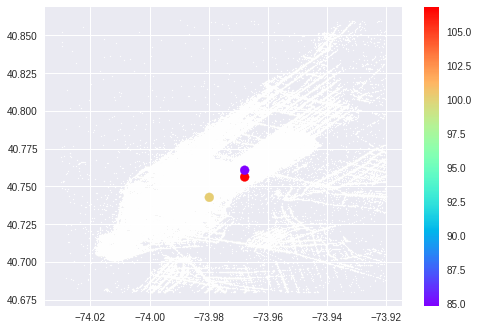

In [ ]:
result_best = spark.sql("""SELECT pickup_latitude, pickup_longitude, week_day, hour, index
                            FROM (SELECT pickup_latitude, pickup_longitude, week_day, hour, index,
                            row_number() over (partition by week_day, hour order by index desc) as rank
                            FROM result)
                            WHERE (rank BETWEEN 1 AND 3) AND (week_day = 3) AND (hour = 2)                       
                          """)

spark_df.createOrReplaceTempView("data")
ny = spark.sql("""SELECT pickup_longitude as x, pickup_latitude as y
                FROM data WHERE (pickup_longitude BETWEEN -74.03 AND -73.92)
                AND (pickup_latitude BETWEEN 40.68 AND 40.86)  """)
ny_pd = ny.toPandas()

results = result_best.toPandas()

print('Plotting the best pickups for Wednesday, 2am')
f, ax = plt.subplots(1)
ax.scatter(x=ny_pd["x"],y=ny_pd["y"],s=1, c="w")

p = ax.scatter(results["pickup_longitude"], results["pickup_latitude"], c = results["index"],s=80,cmap="rainbow")

plt.colorbar(p)
plt.show()

#### **Discussion**

When creating an index for the taxi drivers we wanted to take into account as many measures as possible. Thus, we considered the amount of different pickups, the fare amount, the trip distance and the amount of tips to be relevant. The fare amount is important because taxis drivers profit from a higher fare amount and might prefer higher distances over short distance trips. Furthermore, we considered the fare amount instead of the total amount because the total amount also includedes the tip and we separatly have a look at the tip. As its important to have a high distance and a high fare amount there should also be several customers in need of a trip. Furthermore, taxis drivers prefer a high tip over no tip. 
First, we created for the same hour, weekday and pickup location the average driving distance, fare amount and tip amount as well as the number of pickups. 

Then we did the final ranking. Therefore, we created an index column that contains the final value. Therefore, we multiplied each chosen variable with a weight and added all the weighted variables up. As all of them have a the higher the better measure, it is possible to say that the highest final value is the best. We valued the number of pickups and the fare amount as most important and thus, gave each a 30% weight. The tip amount and the trip distance are less important and therefore get a weight of each 20%

Next, we created an option to get the top 3 locations for a weekday and hour based on what a taxi driver chose as an input. It is important to say that day 0 is sunday. 

Lastly, for our app, we didn't just want to give the taxi driver the coordinates, but also visual feedback. Therefore, we plotted NY in white (to get the silhouette), and then also plotted the top 3 points for the day and hour the taxi driver put as input (Wednesday, 2am), with a colormap that should give feedback based on how valuable our calculation deemed the point. 
This would allow the taxi driver to decide themselves, where they'd rather drive, complemented on information they might have (e.g., it'd take me way too long to get there in the first place; or, currently there is a construction site in this area, let me rather drive to point 2) 

## Exercise 4

The fourth question intends to help define the location of taxi ranks (the places where taxis stop waiting for collecting clients) in a way that tries to minimize the distance a client needs to travel to reach the taxi rank.

Consider that you want to establish, at least, 100 taxi ranks but no more than 150 - present the code that defines the number and locations of the ranks.

**Note:** This dataset is for NYC taxis. So, pickups outside of the city are infrequent and not representative of the demand in such areas. As such, you should focus on pickups in a square that includes NYC (it is ok if the square includes parts outside of the city). Use, for example, the following square:
```
northLatitude = 40.86
southLatitude = 40.68
eastLongitude = -74.03
westLongitude = -73.92
```

**Suggestion:** Plot your results as a heatmap, with the color being a measurement of the value of the taxi rank; use the visual feedback to enhance your solution.

### Select only the area that includes NYC and plot

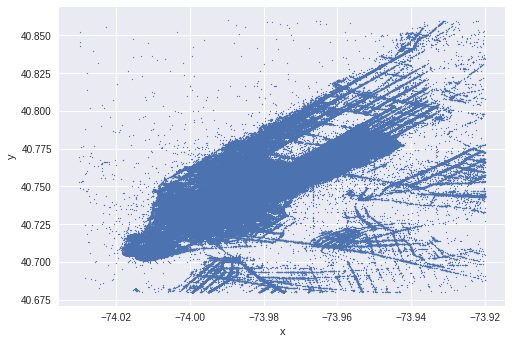

In [ ]:
spark_df.createOrReplaceTempView("data")

ny = spark.sql("""SELECT pickup_longitude as x, pickup_latitude as y
                FROM data WHERE (pickup_longitude BETWEEN -74.03 AND -73.92)
                AND (pickup_latitude BETWEEN 40.68 AND 40.86)  """)
ny_pd = ny.toPandas()
ny_pd.plot.scatter(x="x",y="y",s=1)

### Finding out how many taxistands to put up
DO NOT EXECUTE, TAKES 2 HOURS!

In [ ]:
# Create the features column
assembler = VectorAssembler(inputCols=('x','y'),outputCol="features")
ny = assembler.transform(ny)

142


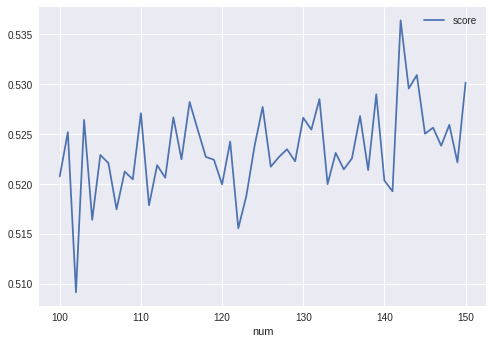

In [ ]:
# Function to perform clustering of dataset data with K clusters, 
# returning the Silhouette score
def evaluate(dataset, k):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(dataset)
    predictions = model.transform(dataset)
    evaluator = ClusteringEvaluator()
    score = evaluator.evaluate(predictions)
    return score

# For each value from 100 to 150 compute the clusters and the score
df = pd.DataFrame(columns=['num','score'])
for i in range(100,151):
    df = pd.concat([df,pd.Series({"num": i, "score": evaluate(ny,i)}).to_frame().T], ignore_index=True)

# Plot the scores    
df.plot( x="num", y="score")
k = int(df.nlargest(1,"score")["num"].values[0])
print(k)

the graph shows, that 142 receives the highest score

### k-means cluster

In [ ]:
# Create the features column: Auxiliary class used to create a column composed by the values of other columns
assembler = VectorAssembler(inputCols=('x','y'),outputCol="features")
ny = assembler.transform(ny)

# Initialize the algorithm for 142 cluster
# setSeed to a constant allows to repeat the computation and generate exactly the same clusters
kmeans = KMeans().setK(142).setSeed(1)

# Generate a model from the dataset
model = kmeans.fit(ny)

# Shows the result.
centers = model.clusterCenters()

+----------+---------+--------------------+----------+
|         x|        y|            features|prediction|
+----------+---------+--------------------+----------+
|-73.956528|40.716976|[-73.956528,40.71...|        80|
|-73.973145|40.752827|[-73.973145,40.75...|        35|
|-74.004173|40.720947|[-74.004173,40.72...|        65|
|-73.987373|40.724861|[-73.987373,40.72...|       113|
|-73.955383|40.779728|[-73.955383,40.77...|       131|
+----------+---------+--------------------+----------+
only showing top 5 rows



/usr/local/lib/python3.8/dist-packages/pyspark/sql/pandas/conversion.py:114: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.pyspark.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT()
Attempting non-optimization as 'spark.sql.execution.arrow.pyspark.fallback.enabled' is set to true.
  warn(msg)


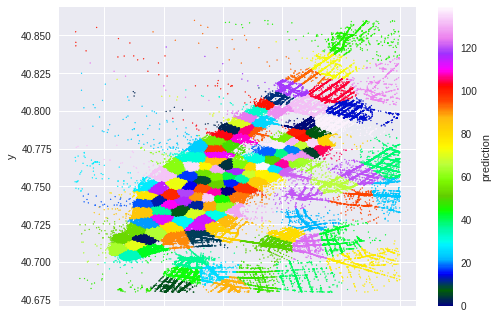

In [ ]:
# Assign each element of the data set to a cluster number
# This comes up with the prediction column that defines the prediction that shows which attribute qualifies for which category
predictions = model.transform(ny)

# Let's print 10 elements
predictions.show(5)

predictionsPD = predictions.toPandas()
# Display results, using the cluster number as the color
predictionsPD.plot.scatter(x="x",y="y",c="prediction",s=1,cmap='gist_ncar')

20 Clusters: Quality of predictions (higher is better):0.5441736508577458


In [ ]:
# Evaluate the quality of the prediction
evaluator = ClusteringEvaluator()
score = evaluator.evaluate(predictions)

print( "Quality of predictions (higher is better):" + str(score))

Quality of predictions (higher is better):0.5203580532189047


In [ ]:
ctr_count = predictionsPD.groupby(["prediction"])["prediction"].count() # count how many points are in each cluster
centers_df = pd.DataFrame(centers, columns=["lon", "lat"]) # transform the centers array to a dataframe
centered_df = centers_df.join(ctr_count) # contains the longitude and latitude of the centers with the number of points in each center
centered_df.head(5)

,lon,lat,prediction
0,-73.978450,40.746782,18600
1,-73.953428,40.790305,6623
2,-74.007153,40.715248,12300
3,-73.976956,40.787853,12805
4,-73.978838,40.763663,28420


### Display the taxistands and their value

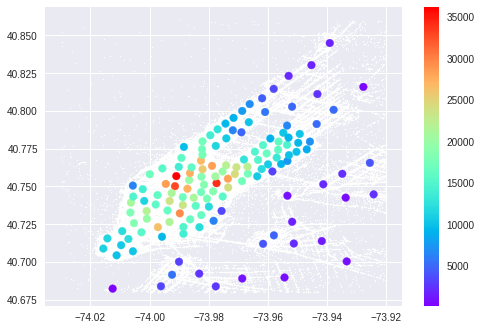

In [ ]:
f, ax = plt.subplots(1)
ax.scatter(ny_pd["x"], ny_pd["y"], c="w", s=1)
p = ax.scatter(centered_df["lon"], centered_df["lat"], c = centered_df["prediction"],s=60,cmap="rainbow")

plt.colorbar(p)

#### Discussion

First, we determined how many taxistands should be put up, which is equivalent to the number of clusters. We did this by conducting a silhouette analysis. This means, calculating the silhouette score for each possible number of cluster (100 to 150), to determine how good the resulting cluster is. 
The silhouette score measures how close an element is to its own cluster compared to other clusters, so it can be used to determine if the clusters are clearly distinguishable.
The silhouette analysis concluded that 142 would be the best number of clusters to use.

Second, we ran the k-means cluster algorithm with the number of clusters found out as input k. The algorithm assigns each element of the ny data set to a cluster number.

Third, we wanted to plot the centroids of the clusters, which are the points where the taxistand should be put up. We wanted to plot the results as a heatmap, which takes the value of the taxistand into account. The value of the taxistand in this case is not related to any measures that the taxidriver would benefit from. Instead, since the taxistands are supposed to minimize the distance a client needs to travel to reach the taxi rank, the value of the taxistand is how many pickup-points are included in the cluster.

## Exercise 5

Propose a problem that you think would be useful to solve with the given dataset.

**Explain the problem you propose to solve**

### Page rank algorithm

In [ ]:
# Squares of 500 meters
latitudeStep = 0.004491556
longitudeStep = 0.005986
northLatitude = 41.474937 - 0.5 * latitudeStep
southLatitude = northLatitude - 300 * latitudeStep
eastLongitude = -74.913585 - 0.5 * longitudeStep
westLongitude = eastLongitude + 300 * longitudeStep

# function to round longitude to a point in the middle of the square
def longiRound( val):
    return ((val - eastLongitude) // longitudeStep) * longitudeStep + eastLongitude + longitudeStep / 2
spark.udf.register("longround", longiRound, DoubleType())

# function to round latitude to a point in the middle of the square
def latRound( l):
    return northLatitude - ((northLatitude - l) // latitudeStep) * latitudeStep - latitudeStep / 2
spark.udf.register("latround", latRound, DoubleType())


# Let's filter data outside of the box and build a grid
# Points in each square are mapped to the center of the square.
spark_df.createOrReplaceTempView("data")
filteredDataDF = spark.sql( """SELECT medallion, hack_license, pickup_datetime,
                                    dropoff_datetime, trip_time_in_secs, trip_distance,
                                    longround(pickup_longitude) AS pickup_longitude, 
                                    latround(pickup_latitude) AS pickup_latitude,
                                    longround(dropoff_longitude) AS dropoff_longitude, 
                                    latround(dropoff_latitude) AS dropoff_latitude, 
                                    payment_type, fare_amount, mta_tax, 
                                    tip_amount, tolls_amount, total_amount
                                  FROM data
                                  WHERE pickup_longitude >= """ + str(eastLongitude) + """ AND
                                  pickup_longitude <=  """ + str(westLongitude) + """ AND
                                  dropoff_longitude >=  """ + str(eastLongitude) + """ AND
                                  dropoff_longitude <=  """ + str(westLongitude) + """ AND
                                  pickup_latitude <= """ + str(northLatitude) + """ AND
                                  pickup_latitude >= """ + str(southLatitude) + """ AND
                                  dropoff_latitude <=  """ + str(northLatitude) + """ AND
                                  dropoff_latitude >=  """ + str(southLatitude))
filteredDataDF.createOrReplaceTempView("data")
filteredDataDF_1 = spark.sql( """SELECT * FROM data WHERE 
                                        pickup_longitude > -74.09 AND pickup_longitude < -72.5 AND
                                        dropoff_longitude > -74.09 AND dropoff_longitude < -72.5 AND
                                        pickup_latitude > 40.55 AND pickup_latitude < 41.1 AND
                                        dropoff_latitude > 40.55 AND dropoff_latitude < 41.1 """)


In [ ]:
from pyspark.sql import *
from graphframes import *


spark = SparkSession \
    .builder \
    .master("local[*]") \
    .appName("Group project") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")
if IN_COLAB :
    spark.sparkContext.addPyFile('graphframes-0.8.2-spark3.2-s_2.12.jar')
else:
    spark.sparkContext.addPyFile('/usr/local/spark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar')

In [ ]:
filteredDataDF_1.createOrReplaceTempView("data")
filteredData_pagerank = spark.sql(""" SELECT CONCAT(pickup_longitude, ' ', pickup_latitude) AS src, CONCAT(dropoff_longitude, ' ', dropoff_latitude) AS dst,
                              CONCAT(pickup_longitude, ' ', pickup_latitude, ' ', dropoff_longitude, ' ', dropoff_latitude) AS id,
                              pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude FROM data """)
filteredData_pagerank.createOrReplaceTempView("data")

e = spark.sql( """SELECT src, dst FROM data""")
v = spark.sql("""SELECT src as id, pickup_longitude AS longitude, pickup_latitude AS latitude FROM data
                      UNION 
                      SELECT dst AS id, dropoff_longitude AS longitude, dropoff_latitude AS latitude FROM data
                      """)
v.show()

# Create a GraphFrame
g = GraphFrame(v, e)

# Query: Get in-degree of each vertex.
g.inDegrees.show()

+--------------------+----------+------------------+
|                  id| longitude|          latitude|
+--------------------+----------+------------------+
|-73.842091 40.765...|-73.842091| 40.76527115199999|
|-73.985755 40.765...|-73.985755| 40.76527115199999|
|-73.937867 40.846...|-73.937867| 40.84611915999999|
|-73.907937 40.837...|-73.907937| 40.83713604799999|
|-73.806175 40.720...|-73.806175| 40.72035559199999|
|-73.907937 40.697...|-73.907937|40.697897811999994|
|-73.901951 40.617...|-73.901951| 40.61704980399999|
|-73.967797 40.670...|-73.967797| 40.67094847599999|
|-73.848077 40.720...|-73.848077| 40.72035559199999|
|-73.931881 40.679...|-73.931881|40.679931587999995|
|-73.860049 40.742...|-73.860049| 40.74281337199999|
|-73.878007 40.733...|-73.878007| 40.73383025999999|
|-74.033643 40.675...|-74.033643| 40.67544003199999|
|-73.830119 40.832...|-73.830119| 40.83264449199999|
|-73.836105 40.724...|-73.836105|40.724847147999995|
|-73.973783 40.774...|-73.973783| 40.774254263

/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:148: UserWarning: DataFrame.sql_ctx is an internal property, and will be removed in future releases. Use DataFrame.sparkSession instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pyspark/sql/dataframe.py:127: UserWarning: DataFrame constructor is internal. Do not directly use it.
  warnings.warn("DataFrame constructor is internal. Do not directly use it.")


+--------------------+--------+
|                  id|inDegree|
+--------------------+--------+
|-73.991741 40.751...|    2194|
|-73.991741 40.715...|     273|
|-73.949839 40.742...|      46|
|-73.955825 40.652...|      16|
|-73.901951 40.873...|       8|
|-73.770259 40.688...|       2|
|-73.901951 40.720...|       4|
|-73.818147 40.742...|       2|
|-73.860049 40.895...|       5|
|-73.818147 40.724...|       1|
|-73.883993 40.774...|       6|
|-73.734343 40.720...|       1|
|-73.842091 40.926...|       1|
|-73.961811 40.769...|     616|
|-73.997727 40.738...|     595|
|-73.925895 40.702...|      42|
|-73.955825 40.679...|      26|
|-73.794203 40.693...|       1|
|-73.919909 40.805...|      13|
|-73.973783 40.599...|       3|
+--------------------+--------+
only showing top 20 rows



In [ ]:
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.01, maxIter=10)
results_1 = results.vertices.select("id", "pagerank")

results_1.sort(desc("pagerank")).show()

+--------------------+------------------+
|                  id|          pagerank|
+--------------------+------------------+
|-73.991741 40.751...| 33.26717644569945|
|-73.991741 40.747...|21.145728672372243|
|-73.973783 40.751...| 19.43378840213646|
|-73.979769 40.747...|19.340943504743866|
|-73.979769 40.742...|18.419621005429487|
|-73.979769 40.751...|17.837327493359215|
|-73.955825 40.769...| 16.90471612045852|
|-73.973783 40.756...| 16.10300146927745|
|-73.985755 40.747...|15.585625853998147|
|-73.955825 40.774...|15.413994095355285|
|-73.949839 40.774...| 15.00974601056617|
|-73.949839 40.778...|14.655932437689492|
|-73.955825 40.778...|14.582919709699702|
|-73.985755 40.729...|14.425265489629158|
|-73.973783 40.747...|13.772736160537738|
|-73.985755 40.733...|13.725333289407285|
|-73.991741 40.756...|13.486507157254785|
|-73.872021 40.774...|13.379380944260985|
|-73.949839 40.783...| 13.05529772017417|
|-73.967797 40.756...| 13.02229947163144|
+--------------------+------------

In [ ]:
results_1_pd = results_1.toPandas()
results_1_pd[["lon", "lat"]] = results_1_pd["id"].str.split(" ", expand=True)
results_1_pd[['lon', 'lat']] = results_1_pd[['lon', 'lat']].astype(float)
results_1_pd

,id,pagerank,lon,lat
0,-73.955825 40.635016027999995,0.141445,-73.955825,40.635016
1,-73.901951 40.74730492799999,1.264826,-73.901951,40.747305
2,-73.919909 40.679931587999995,0.217224,-73.919909,40.679932
3,-73.901951 40.88205160799999,0.354164,-73.901951,40.882052
4,-73.895965 40.724847147999995,0.292174,-73.895965,40.724847
...,...,...,...,...
1958,-73.812161 40.74281337199999,0.088413,-73.812161,40.742813
1959,-73.794203 40.77425426399999,0.063486,-73.794203,40.774254
1960,-73.854063 40.67094847599999,0.069155,-73.854063,40.670948
1961,-73.824133 40.87756005199999,0.108587,-73.824133,40.877560


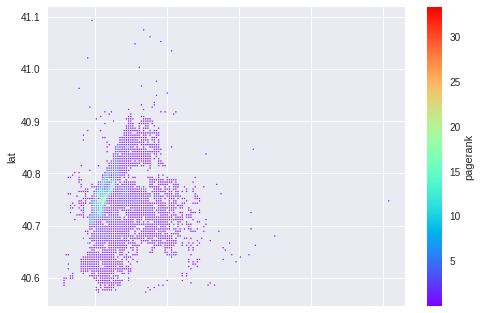

In [ ]:
results_1_pd.plot.scatter(x='lon', y='lat', s=1, c='pagerank', cmap='rainbow')


#### **Discussion**

We wanted to find out, where the most important traffic knots in New York are. This could help the taxi driver with the decision which route to take, since they could avoid these knots at certain times (traffic jams).

Therefore we used the famous Google page-rank algorithm. Google uses it to find out which websites are most relevant, to recommend them at the top of their search engine. The more links to a page, the more imporant it is. Importance of links also depends on the importance of the source page.

Similarly, for our traffic page-rank algorithm, the New York square which has the most "links", is more important.

First, we created a Vertex DataFrame with unique ID column "id", containing the longitude and latitude of pickup points. A vertex is either a starting point. 
Then, we create an Edge DataFrame with "src" and "dst" columns. An edge is representing a link.
After that, we ran the algorihm and ordered the page ranks in a descending way, to get the most important traffic knots. This was then plotted on a map. 